# Toxic Comment Classification Challenge
### by Palermo Penano
This notebook builds a simple feedforward neural network using Keras to identify and classify toxic online comments. The data comes from an active Kaggle [competition](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). It contains comments from Wikipedia's talk page edits where each comment can be labeled as toxic, severely toxic, obscene, threatening, insluting, or exhibiting identity hate.

The model was able to perform 50% better than the simple baseline model where classification is based only on the mean of each possible class.

In [10]:
# system
import os
import pickle

# basic
import pandas as pd
import numpy as np
from scipy import sparse
import tensorflow as tf

# visualization
import matplotlib.pyplot as plt

# feature engineering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss

# ml
from keras import models
from keras import layers
from keras import backend

# settings
from IPython.core.display import display, HTML
pd.set_option('display.max_colwidth', 1000) # display long text pandas dataframe
plt.style.use('ggplot')

# confirm that GPU is available
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5316808100915219530
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 135725056
locality {
  bus_id: 1
}
incarnation: 3094992759038105386
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Load and prepare data
Shuffle it, drop duplicates, fill in missing values, and set training + test set.

In [13]:
# set some parameters

sample_frac = 1.  # set fraction of dataset to be used
test_frac = .20  # test set (set to 0. for full training) !!!
val_frac = .20  # validation set
comment_labels = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']

In [14]:
# load data
df_train = pd.read_csv('train.csv')
print("Total sample size:", df_train.count().loc['id']) 

# Create a sub sample for experimentation
df_train = df_train.sample(frac=sample_frac, random_state=42)
print("{}% sub sample size: {}".format(sample_frac * 100, df_train.count().loc['id']))

# fill in missing values
print("Number missing in training: {}".format(df_train['comment_text'].isnull().sum()))
df_train['comment_text'] = df_train['comment_text'].fillna("_na_").values

# check for duplicates; drop if they exist to 
# ensure disjoint training and validation set
print("Number of duplicated row:", np.sum(df_train.duplicated()))
df_train = df_train.drop_duplicates()

# shuffle dataset
df_train = shuffle(df_train, random_state=42)

# split train and testing
test_index = np.ceil(df_train.shape[0] * test_frac).astype('int')
df_train = df_train[test_index:]
df_test = df_train[:test_index]
print("{}% training set sample size: {}".format((1-test_frac) * 100, df_train.shape[0]))
print("{}% testing set sample size: {}".format(test_frac * 100, df_test.shape[0]))

Total sample size: 159571
100.0% sub sample size: 159571
Number missing in training: 0
Number of duplicated row: 0
80.0% training set sample size: 127656
20.0% testing set sample size: 31915


# Convert comments to learned feature vectors

## Learn vocabulary
We use the `CountVectorizer` class from the `sklean` module to learn the vocabulary of the comments and create a sparse matrix for the top 20,000 words. This is a term-document matrix where each learned vocabulary (20,000 of them based on our `max_features` restriction) is along the column and comments along the rows. Each element in the matrix contain the count of a given word for a given comment. These word vectors will be the features that we will use to feed into the neural network.

In [15]:
def clean_comments(features_dataframe):
    # remove \n character and double spaces
    cleaned_features_dataframe = features_dataframe.str.replace('\n', ' ')
    cleaned_features_dataframe = cleaned_features_dataframe.str.replace('  ', ' ')
    return cleaned_features_dataframe


def fit_count_vectorizer(cleaned_features_dataframe):
    # returns class containing the learned vocabulary
    # dictionary of top 20000 tokens in the comments
    
    # initialize count vectorizer
    count_vector = CountVectorizer(lowercase=True,
                                   stop_words='english',
                                   analyzer='word',
                                   max_features=20000)

    count_vector.fit(cleaned_features_dataframe)
    
    return count_vector

In [16]:
x_train = df_train['comment_text']

cleaned_x_train = clean_comments(x_train)
fitted_count_vector = fit_count_vectorizer(cleaned_x_train)
x_train_sparse_matrix = fitted_count_vector.transform(cleaned_x_train)

print("Shape of vectorized training input:", x_train_sparse_matrix.shape)

Shape of vectorized training input: (127656, 20000)


# Create validation set
Here we create validation set to monitor model performance during training. Note that the dataset has already been shuffled when data was imported.

**`pandas` does not work in `keras` in Ubuntu (see [here](https://stackoverflow.com/questions/33564181/keras-gru-nn-keyerror-when-fitting-not-in-index)). Use numpy arrays instead by transforming the dataframes using the `as_matrix` method.**

In [17]:
# index for 20% of training sample
val_index = np.ceil(df_train.shape[0] * val_frac).astype('int')
print("{}% (of original training sample) validation set sample size: {}".format(val_frac * 100, val_index))

# training set
one_hot_train_labels = df_train[comment_labels].iloc[val_index:]
one_hot_train_labels = one_hot_train_labels.as_matrix()
x_train_nparray = x_train_sparse_matrix[val_index:,:].toarray()

# validation set
one_hot_val_labels = df_train[comment_labels].iloc[:val_index]
one_hot_val_labels = one_hot_val_labels.as_matrix()
x_val_nparray = x_train_sparse_matrix[:val_index,:].toarray()

20.0% (of original training sample) validation set sample size: 25532


In [18]:
print("Training labels shape: {}, type: {}".format(one_hot_train_labels.shape, type(one_hot_train_labels)))
print("Training features shape: {}, type: {}".format(x_train_nparray.shape, type(x_train_nparray)))

print("Validation labels shape: {}, type: {}".format(one_hot_val_labels.shape, type(one_hot_val_labels)))
print("Validation features shape: {}, type: {}".format(x_val_nparray.shape, type(x_val_nparray)))

Training labels shape: (102124, 6), type: <class 'numpy.ndarray'>
Training features shape: (102124, 20000), type: <class 'numpy.ndarray'>
Validation labels shape: (25532, 6), type: <class 'numpy.ndarray'>
Validation features shape: (25532, 20000), type: <class 'numpy.ndarray'>


# Baseline result
We create the baseline results against which we evaluate our model. The baseline model uses the mean of a class as the prediction for the probability of a comment being toxic. The metric used for evaluation is the mean columnwise log loss. It is defined as 

$$
\frac{\text{toxic_logloss} + \text{severe_toxic_logloss} + ... + \text{identity_hate_logloss}}{6}
$$

where $\text{CLASS_logloss}$ is the log loss of a given class.

In [19]:
# metric for evaluation (average of the log losses of each class)
def mean_columnwise_logloss_nparray(y_true, y_pred):
    return np.mean([log_loss(y_true[:, i], y_pred[:, i], eps = 1e-7) for i in range(6)])

In [20]:
y_true_test = df_test[comment_labels].values

# mean of each class baseline
y_pred_baseline_mean = np.zeros(y_true_test.shape)
y_pred_baseline_mean[:] = np.mean(one_hot_train_labels, axis=0)  # assign mean across labels to every row

print(y_pred_baseline_mean.shape)
print(y_pred_baseline_mean[:,0].shape)

print("Mean of each class: mean columnwise log loss =", mean_columnwise_logloss_nparray(y_true_test, y_pred_baseline_mean))

# # always friend baseline
# y_pred_baseline_friendly = np.zeros(y_true_test.shape)
# print("Always friendly: mean columnwise log loss =", mean_columnwise_logloss_nparray(y_true_test, y_pred_baseline_friendly))

(31915, 6)
(31915,)
Mean of each class: mean columnwise log loss = 0.14318019625200637


# Neural network

The labels have already been one hot encoded and saved in the `one_hot_val_labels` variable. We now just need to build the neural network. We will use `relu` as the activation functions in the hidden layers. Because this is a multilabel, multiclass classification problem, we will use the the `sigmoidal` function in the output layer. `softmax` would be more appropriate if we wanted a probability distribution in the case where each comment can only take a single classification.

The end result gives us the probability that a comment is characterized by a class. For example, given the classes 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', a prediction of  \[0.99, 0.89, .95, 0, .88, 0\] for a comment indicates that it is very likely to be both toxic and severly toxic, obscene and insulting. However, it is not predicted to be thtreatening or exhibiting identity hate.

For the optimizer, we will use `rmsprop` to minimize the `binary_crossentropy` loss function. For a good reference on multiclass, multilabel classification, see [here](https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks/).

The goal is to create a model that overfits (gradually decreasing training error and increasing validation error). Once this is achieved, we tune the model to improve its performance.

Below we train three models: one designed to overfit, one based on the previous model but with dropout regularization applied to each hidden layer, and one with much simpler architecture without any regularization. We train all three for 20 epochs and plot their training and validation losses.

In [ ]:
# set to use GPU if available (1 for GPU, 0 for CPU)
config = tf.ConfigProto( device_count = {'GPU': 1} ) 
sess = tf.Session(config=config) 
backend.set_session(sess)

In [22]:
# def overfitting_model(num_epochs):
    
#     model = models.Sequential()
#     model.add(layers.Dense(128, activation='relu', input_shape=(20000,)))
#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.Dense(6, activation='sigmoid'))

#     model.compile(optimizer='rmsprop',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

#     history = model.fit(x_train_nparray,
#                       one_hot_train_labels,
#                       epochs=num_epochs,
#                       batch_size=8000,
#                       validation_data=(x_val_nparray, one_hot_val_labels),
#                       verbose=1)
    
#     return model, history

# # overfitting model
# nn_model_1, history_1 = overfitting_model(20)
# nn_model_1.save('models/overfitting_model.h5')
# with open('models/overfitting_model_history','wb') as f:
#     pickle.dump(history_1.history, f)

In [23]:
# def overfitting_model_w_dropout(num_epochs):
    
#     model = models.Sequential()
#     model.add(layers.Dense(128, activation='relu', input_shape=(20000,)))
#     model.add(layers.Dropout(0.50))
#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.Dropout(0.50))
#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.Dropout(0.50))
#     model.add(layers.Dense(6, activation='sigmoid'))

#     model.compile(optimizer='rmsprop',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

#     history = model.fit(x_train_nparray,
#                       one_hot_train_labels,
#                       epochs=num_epochs,
#                       batch_size=8000,
#                       validation_data=(x_val_nparray, one_hot_val_labels),
#                       verbose=1)
    
#     return model, history

# # dropout regularization
# nn_model_2, history_2 = overfitting_model_w_dropout(20)
# nn_model_2.save('models/overfitting_model_w_dropout.h5')
# with open('models/overfitting_model_w_dropout_history','wb') as f:
#     pickle.dump(history_2.history, f)

In [24]:
# def simple_model(num_epochs):
    
#     model = models.Sequential()
#     model.add(layers.Dense(64, activation='relu', input_shape=(20000,)))
#     model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dense(6, activation='sigmoid'))

#     model.compile(optimizer='rmsprop',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

#     history = model.fit(x_train_nparray,
#                       one_hot_train_labels,
#                       epochs=num_epochs,
#                       batch_size=8000,
#                       validation_data=(x_val_nparray, one_hot_val_labels),
#                       verbose=1)
    
#     return model, history

# nn_model_3, history_3 = simple_model(20)
# nn_model_3.save('models/simple_model.h5')
# with open('models/simple_model_history','wb') as f:
#     pickle.dump(history_3.history, f)

## Plot training and validation loss

In [25]:
def train_val_loss_plot(history):
    train_loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

Text(0.04,0.5,'Loss')

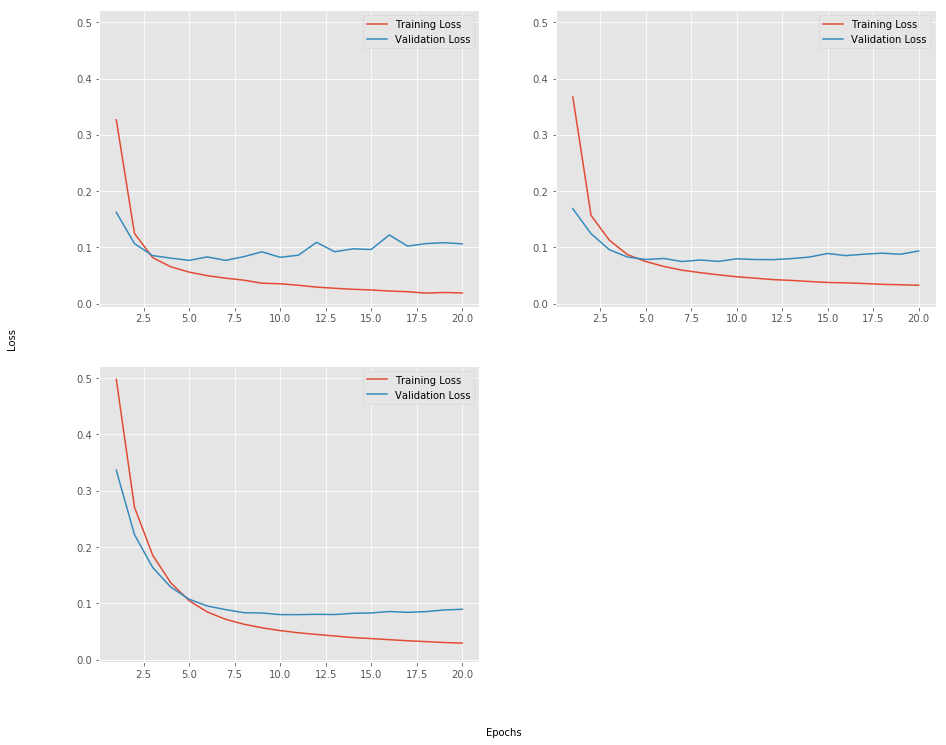

In [26]:
# Plots sharing the same figure

# load both data
pickle_off = open('models/overfitting_model_history', 'rb')
history_1 = pickle.load(pickle_off)

pickle_off = open('models/overfitting_model_w_dropout_history', 'rb')
history_2 = pickle.load(pickle_off)     

pickle_off = open('models/simple_model_history', 'rb')
history_3 = pickle.load(pickle_off)   

# y
train_loss_1 = history_1['loss']
val_loss_1 = history_1['val_loss']

train_loss_2 = history_2['loss']
val_loss_2 = history_2['val_loss']

train_loss_3 = history_3['loss']
val_loss_3 = history_3['val_loss']

# x
epochs = range(1, len(train_loss_1) + 1)


fig = plt.figure(figsize=(15, 12))
ax1 = plt.subplot(221)
ax1.plot(epochs, train_loss_1, label='Training Loss')
ax1.plot(epochs, val_loss_1, label='Validation Loss')
plt.legend()

ax2 = plt.subplot(222, sharey=ax1)
ax2.plot(epochs, train_loss_2, label='Training Loss')
ax2.plot(epochs, val_loss_2, label='Validation Loss')
plt.legend()

ax3 = plt.subplot(223, sharey=ax1)
ax3.plot(epochs, train_loss_3, label='Training Loss')
ax3.plot(epochs, val_loss_3, label='Validation Loss')
plt.legend()

fig.text(0.5, 0.04, 'Epochs', ha='center')
fig.text(0.04, 0.5, 'Loss', va='center', rotation='vertical')

Based on the figures, either the simple model or the model with dropout regularization trained for around 10 epochs appear to be the best among the three. We'll go with the simple model trained for 10 epochs for now and see how this performs compared to the baseline.

In [27]:
def simple_model(num_epochs):
    
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(20000,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(6, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(x_train_nparray,
                      one_hot_train_labels,
                      epochs=num_epochs,
                      batch_size=8000,
                      validation_data=(x_val_nparray, one_hot_val_labels),
                      verbose=1)
    
    return model, history

nn_model_4, history_4 = simple_model(10)
nn_model_4.save('models/simple_model_10_epochs.h5')
with open('models/simple_model_10_epochs_history','wb') as f:
    pickle.dump(history_4.history, f)

Train on 102124 samples, validate on 25532 samples
Epoch 1/10
102124/102124 [==============================] - 15s 148us/step - loss: 0.5138 - acc: 0.8990 - val_loss: 0.3527 - val_acc: 0.9632
Epoch 2/10
102124/102124 [==============================] - 12s 116us/step - loss: 0.2795 - acc: 0.9645 - val_loss: 0.2229 - val_acc: 0.9642
Epoch 3/10
102124/102124 [==============================] - 12s 116us/step - loss: 0.1858 - acc: 0.9664 - val_loss: 0.1630 - val_acc: 0.9672
Epoch 4/10
102124/102124 [==============================] - 12s 116us/step - loss: 0.1359 - acc: 0.9704 - val_loss: 0.1277 - val_acc: 0.9714
Epoch 5/10
102124/102124 [==============================] - 12s 116us/step - loss: 0.1048 - acc: 0.9745 - val_loss: 0.1068 - val_acc: 0.9734
Epoch 6/10
102124/102124 [==============================] - 12s 116us/step - loss: 0.0844 - acc: 0.9775 - val_loss: 0.0941 - val_acc: 0.9749
Epoch 7/10
102124/102124 [==============================] - 12s 118us/step - loss: 0.0709 - acc: 0.9795

## Predictions
We apply the test set to evaluate the performance of our model compare with the baseline prediction. We use the learned vocabulary based on the training set to transform the comments in the test set into a document term matrix. Following this, we create a prediction array for each comment based on the simple model trained above.

In [28]:
%%time

# load model
nn_model_4 = models.load_model('models/simple_model_10_epochs.h5')
x_test = df_test['comment_text']

# clean test set and use the same learned vocabulary on the
# training set to transform the cleaned test set into a sparse matrix
cleaned_x_test = clean_comments(x_test)
x_test_sparse_matrix = fitted_count_vector.transform(cleaned_x_test)
print("Dimension of one hot encoded comments in test set", x_test_sparse_matrix.shape)

# predict using best model
predictions = nn_model_4.predict(x_test_sparse_matrix)

Dimension of one hot encoded comments in test set (31915, 20000)
CPU times: user 4.23 s, sys: 186 ms, total: 4.41 s
Wall time: 4.04 s


In [29]:
# check dimension of test and prediction
print("Shape of labels data in prediction set: ", predictions.shape)
print("Shape of labels data in test set: ", y_true_test.shape)

Shape of labels data in prediction set:  (31915, 6)
Shape of labels data in test set:  (31915, 6)


In [30]:
print("Mean columnwise log loss:", mean_columnwise_logloss_nparray(y_true_test, predictions))

Mean columnwise log loss: 0.07291728688373196


The baseline score where we use the mean of each class as our prediction was around 0.1432. We reduced this by about 50% with our simple two layer feedforward neural network without any regularization. 